In [4]:
# import necessary packages
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tvt

import matplotlib.pyplot as plt

import os
os.chdir('..')

from matplotlib.colors import LinearSegmentedColormap

from functools import reduce
from functools import partial

#   # Create a custom colormap that is inverted
cmap = plt.cm.viridis  # Choose the colormap you want to invert
cmap_inverted = LinearSegmentedColormap.from_list("inverted_viridis", cmap(np.linspace(1, 0, 256)))



from timeit import default_timer
import scipy.io
import os
import sys
from itertools import chain
import time



from models.TrainPlanningOperator4D import PlanningOperator4D, smooth_chi
from models.utilities import *

In [7]:
print("Training Planning Operator")
os.chdir("dataset/manipulator")

lrs = [1e-2]
gammas = [0.5]
wds = [3e-6]
smooth_coefs = [5.]
smooth_coef = smooth_coefs[0]
# experiments to be replicated with different seeds
seeds = [5, 2000, 14000, 16000, 100000]
seeds = [seeds[0]]

################################################################
#                       configs
################################################################
Ntotal = 40*10 + 10*10
ntrain = 40*10
ntest =  10*10

batch_size = 1

epochs = 501
scheduler_step = 100
tol_early_stop = 500


################################################################
# load data and data normalization
################################################################
t1 = default_timer()

sub = 1
Sx = int(((17 - 1) / sub) + 1)
Sy = Sx
Sz = int(((17 - 1) / sub) + 1)
St = Sz

mask = np.load('mask.npy')[:Ntotal,:,:,:]
mask = torch.tensor(mask, dtype=torch.float)
dist_in = np.load('dist_in.npy')[:Ntotal,:,:,:]
dist_in = torch.tensor(dist_in[:Ntotal, :, :], dtype=torch.float)
input = smooth_chi(mask, dist_in, smooth_coef)
output = np.load('output.npy')[:Ntotal,:,:,:]
output = torch.tensor(output, dtype=torch.float)

goals = np.load('goals.npy')[:Ntotal,:]
goals = torch.tensor(goals, dtype=torch.float)


mask_train = mask[:Ntotal][:ntrain, ::sub, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz, :St]
mask_test = mask[:Ntotal][-ntest:, ::sub, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz, :St]

mask_train = mask_train.reshape(ntrain, Sx, Sy, Sz,St, 1)
mask_test = mask_test.reshape(ntest, Sx, Sy, Sz,St, 1)

chi_train = input[:Ntotal][:ntrain, ::sub, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz, :St]
chi_test = input[:Ntotal][-ntest:, ::sub, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz, :St]

chi_train = chi_train.reshape(ntrain, Sx, Sy, Sz, St, 1)
chi_test = chi_test.reshape(ntest, Sx, Sy, Sz, St, 1)

y_train = output[:Ntotal][:ntrain, ::sub, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz, :St]
y_test = output[:Ntotal][-ntest:, ::sub, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz, :St]

y_train = y_train.reshape(ntrain, Sx, Sy, Sz, St, 1)
y_test = y_test.reshape(ntest, Sx, Sy, Sz, St, 1)

goals_train = goals[:ntrain]
goals_test = goals[-ntest:]

goals_train = goals_train.reshape(ntrain, 4, 1)
goals_test = goals_test.reshape(ntest, 4, 1)


train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mask_train, chi_train, y_train, goals_train),
                                            batch_size=batch_size,
                                            shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mask_test, chi_test, y_test, goals_test),
                                            batch_size=batch_size,
                                            shuffle=False)

Training Planning Operator


In [9]:
modes = 3
width = 7
nlayers = 1

model = PlanningOperator4D(modes, modes, modes, modes, width, nlayers)
model.load_state_dict(torch.load("planningoperator_manipulator17_m3_w8_l1_b10_lr3e-3_10g_20nov/n400_lr1.000000e-02_gamma6.000000e-01_wd3.000000e-06_seed5/model4d.ckpt"))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

PlanningOperator4D(
  (fc0): Linear(in_features=4, out_features=7, bias=True)
  (conv0): SpectralConv4d()
  (w0): Conv4d(
    (conv3d_layers): ModuleList(
      (0): Conv3d(7, 7, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    )
  )
  (fc1): DeepNormMetric(
    (Us): ModuleList(
      (0-1): 2 x Linear(in_features=7, out_features=128, bias=False)
    )
    (Ws): ModuleList(
      (0): ConstrainedLinear(in_features=128, out_features=128, bias=False)
    )
    (activation): MaxReLUPairwiseActivation(
      (avg_pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (output_activation): ConcaveActivation()
    (reduce_metric): ReduceMetric()
  )
)

In [18]:
# Primary movements in 4D: forward, backward, left, right, up, down, and movements in the 4th dimension
primary_moves_4d = [
    [-1., 0., 0., 0.],  # left
    [1., 0., 0., 0.],   # right
    [0., 1., 0., 0.],   # forward
    [0., -1., 0., 0.],  # backward
    [0., 0., 1., 0.],   # up
    [0., 0., -1., 0.],  # down
    [0., 0., 0., 1.],   # positive w
    [0., 0., 0., -1.]   # negative w
]

# Diagonal movements in 4D
diagonal_moves_4d = [
    [-1., 1., 0., 0.],  # left-forward
    [-1., -1., 0., 0.], # left-backward
    [1., 1., 0., 0.],   # right-forward
    [1., -1., 0., 0.],  # right-backward
    [-1., 0., 1., 0.],  # left-up
    [-1., 0., -1., 0.], # left-down
    [1., 0., 1., 0.],   # right-up
    [1., 0., -1., 0.],  # right-down
    [0., 1., 1., 0.],   # forward-up
    [0., 1., -1., 0.],  # forward-down
    [0., -1., 1., 0.],  # backward-up
    [0., -1., -1., 0.], # backward-down
    [-1., 1., 1., 0.],  # left-forward-up
    [-1., 1., -1., 0.], # left-forward-down
    [-1., -1., 1., 0.], # left-backward-up
    [-1., -1., -1., 0.],# left-backward-down
    [1., 1., 1., 0.],   # right-forward-up
    [1., 1., -1., 0.],  # right-forward-down
    [1., -1., 1., 0.],  # right-backward-up
    [1., -1., -1., 0.], # right-backward-down
    # Additional diagonal movements involving the 4th dimension
    [-1., 0., 0., 1.],  # left-positive w
    [-1., 0., 0., -1.], # left-negative w
    [1., 0., 0., 1.],   # right-positive w
    [1., 0., 0., -1.],  # right-negative w
    [0., 1., 0., 1.],   # forward-positive w
    [0., 1., 0., -1.],  # forward-negative w
    [0., -1., 0., 1.],  # backward-positive w
    [0., -1., 0., -1.], # backward-negative w
    [0., 0., 1., 1.],   # up-positive w
    [0., 0., 1., -1.],  # up-negative w
    [0., 0., -1., 1.],  # down-positive w
    [0., 0., -1., -1.], # down-negative w
]

# Combine primary and diagonal moves
action_vecs_4d = np.asarray(primary_moves_4d + diagonal_moves_4d)

def perform_gradient_descent(value_function, start_point, goal_point, plotsuccess=False, plotfails=False, learning_rate=1, num_steps=1000):
    path_length = 0
    path_points = [start_point.copy().astype(float)]
    visited_points = set()
    current_point = start_point.copy().astype(float)

    for step in range(num_steps):
        best_gradient = np.inf
        best_action = None

        for action in action_vecs_4d:
            new_point = current_point + learning_rate * action
            new_point_indices = np.round(new_point).astype(int)
            x_index, y_index, z_index, w_index = new_point_indices

            if (0 <= x_index < value_function.shape[0] and 
                0 <= y_index < value_function.shape[1] and 
                0 <= z_index < value_function.shape[2] and
                0 <= w_index < value_function.shape[3] and
                (x_index, y_index, z_index, w_index) not in visited_points):
                gradient = value_function[x_index, y_index, z_index, w_index]
                if gradient < best_gradient:
                    best_gradient = gradient
                    best_action = action

        if best_gradient > 100:
            if plotfails:
                print("Failed Path:")
            return False, 0, path_points  

        if best_action is not None:
            current_point += learning_rate * best_action
            path_length += np.linalg.norm(learning_rate * best_action)
            path_points.append(current_point.copy())
            visited_points.add(tuple(np.round(current_point).astype(int)))
            if np.array_equal(np.round(current_point).astype(int), np.round(goal_point).astype(int)):
                if plotsuccess:
                    print("Successful Path:")
                    visited_points.add(goal_point)
                return True, path_length, path_points  # Success
        else:
            if plotfails:
                print("Failed Path:")
            return False, 0, path_points  # No valid action found
    if plotfails:
        print("Failed Path:")
    return False, 0 ,path_points 

In [30]:
mask_train.shape

torch.Size([400, 17, 17, 17, 17, 1])

In [67]:
# Compare against classical Planners
nosuceesscount = 0
notime = 0
nopath = 0

with torch.no_grad():
    for batch_id, (mask, chi, ground_truth, gg) in enumerate(test_loader):
        mask, chi, ground_truth, gg = mask.to(device)[0,:,:,:,:,0].reshape(1,Sx,Sy,Sz,St,1), chi.to(device)[0,:,:,:,:,0].reshape(1,Sx,Sy,Sz,St,1), ground_truth.to(device)[0,:,:,:,:,0].reshape(1,Sx,Sy,Sz,St,1), gg.to(device)[0,:,0].reshape(1,4,1)
        goal_point = np.array([13,8,8,10])
        gg = torch.tensor(goal_point, device=device).reshape(1, 4, 1)
        start_point = np.array([8,8,8,7])

        if batch_id==100:
            break    

        # Neural Operator Planning
        # t1 = tic()
        predicted_output = model(chi, gg)
        predicted_output = torch.where(mask == 0, torch.tensor(float('inf')), predicted_output)
        value_function = predicted_output[0, :, :, :, :, 0].cpu().detach().numpy()
        success_po, pathlength_po, path  = perform_gradient_descent(value_function,start_point,goal_point,learning_rate=1)
        # dt = toc(t1)

        # if(success_po):
        #     nosuceesscount+=1
        #     nopath+=pathlength_po

        # value_function_fmm = ground_truth
        # value_function_fmm = torch.where(mask == 0, torch.tensor(float('inf')), value_function_fmm)
        # value_function_fmm = value_function_fmm[0, :, :, :, :, 0].cpu().detach().numpy()
        # success_fmm, pathlength_fmm, _  = perform_gradient_descent(value_function_fmm,start_point,goal_point,learning_rate=1)
        # dt = toc(t1)

        # if(success_fmm):
        #     fmmsuceesscount+=1
        #     fmmpath+=pathlength_fmm     


  


print("Planning Operator\nPath Lenght",pathlength_po,
      "\nSuccess:",success_po)


Planning Operator
Path Lenght 5.146264369941973 
Success: True


In [68]:
path

[array([5., 9., 9., 9.]),
 array([4., 8., 8., 9.]),
 array([3., 8., 8., 8.]),
 array([2., 8., 8., 8.]),
 array([1., 8., 8., 8.])]

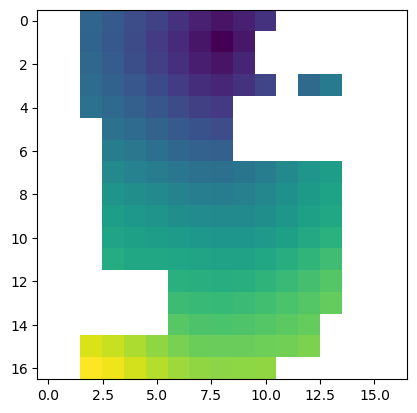

In [69]:
plt.imshow(value_function[:,:,8,8])